# Imports and Functions

In [ ]:
from ml_experiments.utils import unflatten_dict, update_recursively
from ml_experiments.tuners import OptunaTuner
from sklearn.metrics.cluster import adjusted_rand_score
from cohirf.experiment.spherical_clustering import generate_spherical_clusters, visualize_3d_data
from cohirf.models.cohirf_parents import ModularCoHiRF
from cohirf.models.kernel_kmeans import KernelKMeans
from cohirf.models.pseudo_kernel import PseudoKernelClustering
from cohirf.models.lazy_minibatchkmeans import LazyMiniBatchKMeans
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, make_blobs
from sklearn.manifold import TSNE
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dask_ml.datasets import make_blobs as dask_make_blobs
from dask_ml.preprocessing import StandardScaler as DaskStandardScaler
import optuna
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def training_fn(trial, model_cls, model_kwargs, features, true_labels):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(features)
    return adjusted_rand_score(true_labels, labels)

# Dataset (easy)

In [89]:
random_state_dataset = 42
n_samples = 1000
n_features = 10
n_clusters = 5
distance = 5
cluster_std = 1
rng = np.random.default_rng(random_state_dataset)
# Generate equally spaced centers using a regular simplex
# Start with a random orthonormal basis in P dimensions
centers = rng.standard_normal((n_clusters, n_features))
centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
centers = centers.T
# Scale the simplex to achieve the desired pairwise distance
centers *= distance / np.sqrt(2)
X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state_dataset,
)
scaler = StandardScaler()
X = scaler.fit_transform(X)

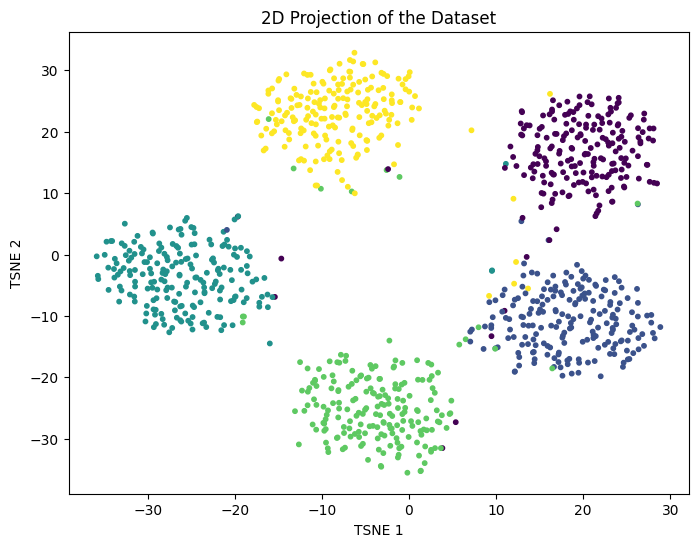

In [90]:
# visualize with 2D projection (TSNE)
tsne = TSNE(n_components=2, random_state=random_state_dataset)
X_2d = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="viridis", s=10)
ax.set_title("2D Projection of the Dataset")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.show()

## KMeans

In [91]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = KMeans
    search_space = {
        "n_clusters": optuna.distributions.IntDistribution(2, 10),
    }
    model_kwargs = {
        "random_state": random_state_model,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:12,341] A new study created in memory with name: no-name-5cc44bea-461f-46c4-83fa-6f2b8c67ab14


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:12,528] A new study created in memory with name: no-name-33ca9f5a-de6a-42dd-bd2f-a0babf30da17


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:12,685] A new study created in memory with name: no-name-3197745e-852c-4790-9caa-9d78f1a04756


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:12,847] A new study created in memory with name: no-name-7091efd1-d1e7-42ab-945d-3cd93d9e6126


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:13,018] A new study created in memory with name: no-name-d72a24e0-f659-46b7-9847-95439bfd0bf3


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:13,179] A new study created in memory with name: no-name-729eb78e-7cae-4639-8ada-0e1dd4ba0a27


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:13,355] A new study created in memory with name: no-name-4505b527-cb37-4eeb-89c5-636c7d945d3b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:13,521] A new study created in memory with name: no-name-ff4a02d9-48b3-43c2-ae38-114946fbbac9


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:13,682] A new study created in memory with name: no-name-45e992bf-5799-4908-9aac-6ef1fe480ad6


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:13,846] A new study created in memory with name: no-name-804fb2fa-91cf-4af7-a1f1-6b470e302f35


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [92]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,n_clusters
7270,0.921477,5,5
860,0.919080,5,5
5390,0.871648,6,6
5191,0.923953,5,5
5734,0.919080,5,5
6265,0.921477,5,5
466,0.919080,5,5
4426,0.919080,5,5
5578,0.923953,5,5
8322,0.921477,5,5


Max Best Value: 0.9239527770017149, Min Best Value: 0.8716483189126953, Std Best Value: 0.01571094161188624


## KMeans PCA

In [93]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = PseudoKernelClustering
    search_space = {
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "base_model": KMeans,
        "base_model_kwargs": dict(random_state=random_state_model),
        "transform_method": PCA,
        "transform_kwargs": dict(random_state=random_state_model),
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:14,080] A new study created in memory with name: no-name-eb214b2a-2c78-4f67-9cdc-33c2f55b83d3


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:14,268] A new study created in memory with name: no-name-07e5d8ce-2b0f-4ae7-8c04-389f44a74ab2


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:14,433] A new study created in memory with name: no-name-12286cdd-ef4c-4b8d-844e-c953b8a95b03


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:14,646] A new study created in memory with name: no-name-92c7b6ac-5b64-4d8f-8af1-01e834dcc53a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:14,828] A new study created in memory with name: no-name-b188d52a-acc4-4983-a1c6-dadfbe47c8b6


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:15,012] A new study created in memory with name: no-name-865751d0-0cce-4a43-91dc-20242f4d07d5


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:15,191] A new study created in memory with name: no-name-f15464ec-e1e9-4a9f-974d-a1d7ad04acc1


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:15,373] A new study created in memory with name: no-name-4a820957-a791-4bbb-9e6e-ad26bb16012f


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:15,539] A new study created in memory with name: no-name-cfec72f9-74a4-4a9b-b655-d01f86a45e8a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:15,707] A new study created in memory with name: no-name-28bd5616-6cdc-4473-917f-2ef2738b9082


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [94]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,base_model_kwargs/n_clusters
7270,0.921477,5,5
860,0.919080,5,5
5390,0.871648,6,6
5191,0.923953,5,5
5734,0.919080,5,5
6265,0.921477,5,5
466,0.919080,5,5
4426,0.919080,5,5
5578,0.923953,5,5
8322,0.921477,5,5


Max Best Value: 0.9239527770017149, Min Best Value: 0.8716483189126953, Std Best Value: 0.01571094161188624


## Kernel KMeans

In [95]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = KernelKMeans
    search_space = {
        "gamma": optuna.distributions.FloatDistribution(2, 10),
    }
    model_kwargs = {
        'n_clusters': 5,
        'kernel': 'rbf',
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:15,973] A new study created in memory with name: no-name-b7b56dfd-8a66-4919-b2ef-ea8de71e865e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:17,240] A new study created in memory with name: no-name-83a172dd-6cea-475a-8b59-b57f505eaaf8


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:18,303] A new study created in memory with name: no-name-0a5f6b6c-a214-4927-88e8-9e06a8d3408b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:19,776] A new study created in memory with name: no-name-8a7eaeaa-5e3c-4b03-96a6-098121ad5006


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:20,952] A new study created in memory with name: no-name-c1aef691-7a65-4ada-afe1-96876c9e9ce7


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:22,462] A new study created in memory with name: no-name-e42c28a5-41b7-49bb-a430-7449cad08095


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:23,500] A new study created in memory with name: no-name-a07e51c0-dd74-4244-ae20-88cf39ddc36a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:24,678] A new study created in memory with name: no-name-64677fbb-aa9c-4cad-89f2-e2e4f271e295


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:25,968] A new study created in memory with name: no-name-8ffbf3d1-61d1-4f9d-8d53-b2e0042f0cf0


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:27,393] A new study created in memory with name: no-name-b45becc6-1221-4aec-a3f9-3258a4e9942e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [96]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,gamma
7270,0.003106,5,9.933269
860,0.001693,5,6.249592
5390,0.001834,5,5.292230
5191,0.004255,5,4.367798
5734,0.002820,5,4.732390
6265,0.004117,5,7.937201
466,0.002088,5,2.063529
4426,0.002014,5,6.323473
5578,0.002393,5,8.142354
8322,0.002135,5,7.375115


Max Best Value: 0.004254795683032181, Min Best Value: 0.001693373708001536, Std Best Value: 0.0009187848204050747


## CoHiRF Base

In [97]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 5)),
        # "transform_kwargs": dict(n_components=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "representative_method": "closest_overall",
        # "n_features": "full",
        "base_model": KMeans,
        # "transform_method": PCA,
        # "transform_kwargs": {},
        "random_state": random_state_model,
        "sample_than_transform": True,
    }
    training_fn_model = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y)
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:28,452] A new study created in memory with name: no-name-7a970cd9-8ae9-4bc9-a871-5c8436b5c590


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:30,077] A new study created in memory with name: no-name-3d96c3cf-6cf5-4771-8c81-cf879c131107


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:31,986] A new study created in memory with name: no-name-189402a7-0a5f-4a87-a901-6ecae2cdd88d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:33,801] A new study created in memory with name: no-name-b71c6f60-4d05-478d-aa32-d522e8688c53


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:35,395] A new study created in memory with name: no-name-71929b72-e0e6-4b77-9272-a01bca03906d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:35,395] A new study created in memory with name: no-name-88cfd54d-2276-4a1b-b94a-1d7b55d21700


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:37,275] A new study created in memory with name: no-name-8b963575-27c0-437b-9460-bbb0f1d179ca


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:39,409] A new study created in memory with name: no-name-a940db97-912e-4c86-9e68-5b8329c8a371


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:40,825] A new study created in memory with name: no-name-c471e0a2-3e05-4ac9-b22a-b7c7ceb173ac


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:42,375] A new study created in memory with name: no-name-01d02ea4-eb5c-4b4e-a0c0-1dbb28ce9da3


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [98]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,repetitions,n_features,base_model_kwargs/n_clusters
7270,0.896793,7,3,8,5
860,0.855774,5,4,7,3
5390,0.889735,12,4,10,5
5191,0.914333,5,2,9,5
5734,0.916882,5,2,10,5
6265,0.915930,8,4,10,5
466,0.895440,8,5,10,5
4426,0.899871,5,2,10,4
5578,0.897122,6,2,10,4
8322,0.903647,6,2,10,5


Max Best Value: 0.9168821980798239, Min Best Value: 0.8557738326462528, Std Best Value: 0.017755239369578197


## CoHiRF Base + PCA

In [99]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        # "n_features": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 5)),
        "transform_kwargs": dict(n_components=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "representative_method": "closest_overall",
        "n_features": 'full',
        "base_model": KMeans,
        "transform_method": PCA,
        # "transform_kwargs": {},
        "random_state": random_state_model,
        "sample_than_transform": True,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:43,917] A new study created in memory with name: no-name-25822670-3afb-4bd8-bf28-a76f0b35e7ce


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:45,473] A new study created in memory with name: no-name-76f26cb8-f914-427e-8536-b93c31bf98c7


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:47,104] A new study created in memory with name: no-name-4e518aee-5910-410a-a197-3c32e6c130f9


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:48,348] A new study created in memory with name: no-name-f6daa3b3-4d24-4a3b-94dd-a72db6806307


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:49,686] A new study created in memory with name: no-name-64d5a253-dbd1-48a3-a296-768fbbb15a20


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:50,924] A new study created in memory with name: no-name-1d5b4034-15ee-4769-850c-e45b070aa658


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:52,777] A new study created in memory with name: no-name-57814e86-68af-4a3a-94d4-a95d71747f93


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:54,243] A new study created in memory with name: no-name-7f8c46fc-622e-476f-b794-3c13faac6da5


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:55,921] A new study created in memory with name: no-name-a1fc6549-87da-4a15-ad27-86a58c824364


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:36:57,515] A new study created in memory with name: no-name-fdf44dec-ac36-4084-8e41-d45d9d25ee17


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [100]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,repetitions,base_model_kwargs/n_clusters,transform_kwargs/n_components
7270,0.921561,5,2,5,7
860,0.923888,5,5,5,5
5390,0.923953,5,2,5,7
5191,0.926370,5,2,5,9
5734,0.923953,5,2,5,7
6265,0.923953,5,3,5,10
466,0.923953,5,3,5,6
4426,0.926357,5,2,5,9
5578,0.925132,6,2,5,9
8322,0.923953,5,2,5,8


Max Best Value: 0.9263698157700425, Min Best Value: 0.9215612384512495, Std Best Value: 0.0013936985339951752


# Dataset (hard)

In [101]:
random_state_dataset = 42
n_samples = 1000
n_features = 10
n_clusters = 5
distance = 3.5
cluster_std = 1
rng = np.random.default_rng(random_state_dataset)
# Generate equally spaced centers using a regular simplex
# Start with a random orthonormal basis in P dimensions
centers = rng.standard_normal((n_clusters, n_features))
centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
centers = centers.T
# Scale the simplex to achieve the desired pairwise distance
centers *= distance / np.sqrt(2)
X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state_dataset,
)
scaler = StandardScaler()
X = scaler.fit_transform(X)

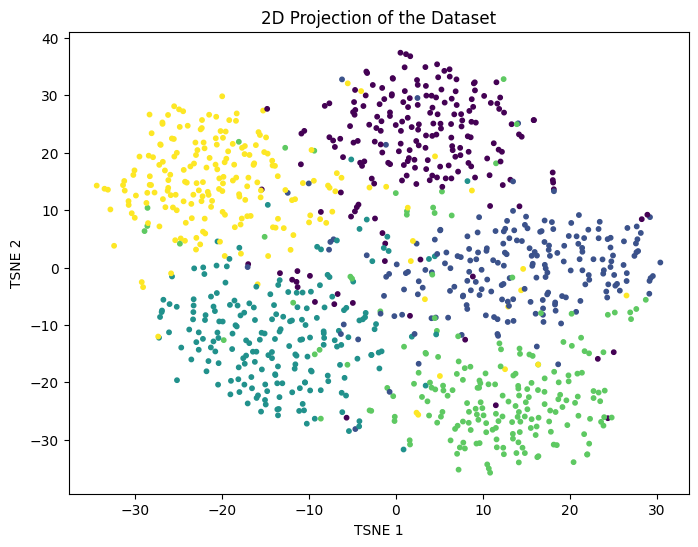

In [102]:
# visualize with 2D projection (TSNE)
tsne = TSNE(n_components=2, random_state=random_state_dataset)
X_2d = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', s=10)
ax.set_title("2D Projection of the Dataset")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.show()

## KMeans

In [103]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = KMeans
    search_space = {
        "n_clusters": optuna.distributions.IntDistribution(2, 10),
    }
    model_kwargs = {
        "random_state": random_state_model,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:08,199] A new study created in memory with name: no-name-c6e4ec4a-5863-4798-b2f5-d25a6634c369


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:08,395] A new study created in memory with name: no-name-82f3ce33-452a-47ad-b749-849df6fbc9ea


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:08,568] A new study created in memory with name: no-name-2cbc6bb9-f074-4eb2-affd-516bd0c82695


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:08,745] A new study created in memory with name: no-name-eb379c8a-e37c-4cf0-83e8-09a2337b8ad4


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:08,923] A new study created in memory with name: no-name-2d77b324-6b49-4c57-b939-a356067001bd


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:09,097] A new study created in memory with name: no-name-03ed4d93-42bf-4118-9ad7-7df01d4da8b6


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:09,264] A new study created in memory with name: no-name-e5593adb-9aed-4c98-bd65-c65a4fe4902b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:09,448] A new study created in memory with name: no-name-213fb611-490c-4244-8a29-ce7184f621ce


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:09,708] A new study created in memory with name: no-name-95a6f896-66a1-4b04-a403-f33bec0d6a75


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:09,875] A new study created in memory with name: no-name-1f199990-8273-455a-9202-dda91efc7c1e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [104]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,n_clusters
7270,0.750075,5,5
860,0.749639,5,5
5390,0.751821,5,5
5191,0.747643,5,5
5734,0.747681,5,5
6265,0.752093,5,5
466,0.747589,5,5
4426,0.754218,5,5
5578,0.749892,5,5
8322,0.749952,5,5


Max Best Value: 0.7542176651779648, Min Best Value: 0.7475893685226, Std Best Value: 0.0021690277767413588


## KMeans PCA

In [105]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = PseudoKernelClustering
    search_space = {
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "base_model": KMeans,
        "base_model_kwargs": dict(random_state=random_state_model),
        "transform_method": PCA,
        "transform_kwargs": dict(random_state=random_state_model),
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:10,095] A new study created in memory with name: no-name-58c47261-c1b8-4e4a-8522-4c2ff2aab259


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:10,309] A new study created in memory with name: no-name-4db34714-fd1e-4ca1-bec4-956e0a7fca86


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:10,484] A new study created in memory with name: no-name-690cda0c-1bf8-4ff5-8b89-68dc8d276db2


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:10,673] A new study created in memory with name: no-name-30d26892-c22b-48c1-b428-743269e292de


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:10,868] A new study created in memory with name: no-name-ae087143-ca7c-4f4f-bfc5-1c4c0b7f52a4


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:11,049] A new study created in memory with name: no-name-b5dc8244-7be6-4ed4-9186-31e2bb94fb22


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:11,221] A new study created in memory with name: no-name-216c3188-73e9-4c8c-843b-b855582d0628


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:11,394] A new study created in memory with name: no-name-05785cd2-2473-4e63-8043-72e8ee6602b2


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:11,574] A new study created in memory with name: no-name-31f00e97-46a4-430d-b8e1-01cc0b42ee3f


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:11,748] A new study created in memory with name: no-name-a672443d-875d-4ea4-acc8-354d657455fd


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [106]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,base_model_kwargs/n_clusters
7270,0.750075,5,5
860,0.749639,5,5
5390,0.751821,5,5
5191,0.747643,5,5
5734,0.747681,5,5
6265,0.752093,5,5
466,0.747589,5,5
4426,0.754218,5,5
5578,0.749892,5,5
8322,0.749952,5,5


Max Best Value: 0.7542176651779648, Min Best Value: 0.7475893685226, Std Best Value: 0.0021690277767413588


## Kernel KMeans

In [107]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = KernelKMeans
    search_space = {
        "gamma": optuna.distributions.FloatDistribution(2, 10),
    }
    model_kwargs = {
        'n_clusters': 5,
        'kernel': 'rbf',
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:11,975] A new study created in memory with name: no-name-0a2f7b8e-659f-4a56-87aa-81fde7e43417


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:13,000] A new study created in memory with name: no-name-ea32be21-215e-4a47-9447-3cad5e3271cd


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:14,020] A new study created in memory with name: no-name-e5ee5bdf-4c53-4e54-833f-81cf4a61837c


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:15,271] A new study created in memory with name: no-name-bc3b4f9e-a099-46df-8adf-39b3dbb20abb


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:16,725] A new study created in memory with name: no-name-dac4198b-353b-4672-804f-cf570eca92b2


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:18,187] A new study created in memory with name: no-name-d6272d53-a692-43a7-81d1-888b7a1bc47f


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:19,230] A new study created in memory with name: no-name-aa70c289-7a7c-441a-8903-8722eba2ab91


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:20,466] A new study created in memory with name: no-name-77910be0-61a6-4e30-8ac9-7f6f5cbf8a72


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:21,652] A new study created in memory with name: no-name-7ceb5ebc-eb43-4dac-964d-998553ceb6f0


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:22,928] A new study created in memory with name: no-name-91d338d3-ca42-4503-acac-c7bbc016fb34


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [108]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,gamma
7270,0.001616,5,9.073841
860,0.002491,5,5.449528
5390,0.001523,5,9.600562
5191,0.003141,5,2.525243
5734,0.002047,5,7.192834
6265,0.002473,5,4.499628
466,0.005690,5,2.469907
4426,0.002358,5,2.055499
5578,0.003136,5,2.019545
8322,0.002782,5,6.521371


Max Best Value: 0.005689558209189434, Min Best Value: 0.0015228947639834183, Std Best Value: 0.0011795265181979784


## CoHiRF Base

In [109]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 5)),
        # "transform_kwargs": dict(n_components=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "representative_method": "closest_overall",
        # "n_features": "full",
        "base_model": KMeans,
        # "transform_method": PCA,
        # "transform_kwargs": {},
        "random_state": random_state_model,
        "sample_than_transform": True,
    }
    training_fn_model = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y)
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:24,014] A new study created in memory with name: no-name-3deb98b3-1831-491e-973e-df5edd56001b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:25,844] A new study created in memory with name: no-name-59a3e425-f089-417f-8eed-61217f81641d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:28,183] A new study created in memory with name: no-name-32df0401-7a07-4160-8b33-49d5b4630b20


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:30,276] A new study created in memory with name: no-name-b30fdfc7-e585-475c-aca6-b36fb3d1bf81


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:31,822] A new study created in memory with name: no-name-03818650-6505-48e3-9b7e-3f65af312e91


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:33,389] A new study created in memory with name: no-name-891efdfe-6225-4a51-8af9-2011d2248b2a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:35,210] A new study created in memory with name: no-name-e6ce91e7-e9dd-4438-9de7-d1f340a831a5


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:37,299] A new study created in memory with name: no-name-fe21b13d-9347-4ee8-9758-9845a32d1e9e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:39,176] A new study created in memory with name: no-name-40a02f58-5221-4efb-ae27-a13b425ca201


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:39,994] A new study created in memory with name: no-name-8d72aa41-b4d3-41f9-9f29-c7b9e3525b87


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [110]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,repetitions,n_features,base_model_kwargs/n_clusters
7270,0.692512,7,3,10,5
860,0.648071,11,5,10,5
5390,0.665260,6,3,10,5
5191,0.707047,6,2,9,5
5734,0.627820,9,3,7,5
6265,0.695186,5,2,10,4
466,0.717317,6,4,9,5
4426,0.673433,14,4,10,5
5578,0.632639,5,4,9,4
8322,0.667028,20,5,9,5


Max Best Value: 0.7173171059464496, Min Best Value: 0.6278197421678099, Std Best Value: 0.030518327871227414


## CoHiRF Base + PCA

In [111]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        # "n_features": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 5)),
        "transform_kwargs": dict(n_components=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "representative_method": "closest_overall",
        "n_features": 'full',
        "base_model": KMeans,
        "transform_method": PCA,
        # "transform_kwargs": {},
        "random_state": random_state_model,
        "sample_than_transform": True,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:42,107] A new study created in memory with name: no-name-e993fd51-e2f9-4e1a-9026-ac250ab82785


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:44,478] A new study created in memory with name: no-name-f6e22882-baa2-4eed-8220-9b178acf137e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:47,284] A new study created in memory with name: no-name-e5ecd2f3-417b-414a-8d92-bb98fd27970a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:49,920] A new study created in memory with name: no-name-9d9d9c19-3f49-4a66-a927-e1dabbf91087


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:52,329] A new study created in memory with name: no-name-8f920957-2dfc-4a9c-9073-b018e64f4c94


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:55,259] A new study created in memory with name: no-name-43cfe71d-ba69-463f-bf36-15e3cfdd34ec


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:38:57,757] A new study created in memory with name: no-name-3ee6841a-4ff2-4dd1-83b2-3df5479eab74


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:39:00,335] A new study created in memory with name: no-name-c734fe9c-5172-469a-9b9d-7155355c0778


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:39:02,830] A new study created in memory with name: no-name-cd7d5c08-c72d-4a2c-93ed-8d1adc8315d0


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:39:05,520] A new study created in memory with name: no-name-07d16125-2154-4261-9fce-6faf46ddacd2


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [112]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,repetitions,base_model_kwargs/n_clusters,transform_kwargs/n_components
7270,0.749562,7,3,5,9
860,0.756720,7,4,5,8
5390,0.755119,6,2,5,8
5191,0.752167,5,2,5,8
5734,0.751871,6,5,5,5
6265,0.752394,6,2,5,7
466,0.756857,6,2,5,6
4426,0.758509,5,3,5,7
5578,0.754222,5,3,5,8
8322,0.758720,5,2,5,8


Max Best Value: 0.7587198953268588, Min Best Value: 0.7495615363860232, Std Best Value: 0.0030889624872479184


# Dataset more samples (easy)

In [132]:
random_state_dataset = 42
n_samples = int(1e5)
n_features = 10
n_clusters = 5
distance = 5
cluster_std = 1
batch_size = int(1e4)
rng = np.random.default_rng(random_state_dataset)
# Generate equally spaced centers using a regular simplex
# Start with a random orthonormal basis in P dimensions
centers = rng.standard_normal((n_clusters, n_features))
centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
centers = centers.T
# Scale the simplex to achieve the desired pairwise distance
centers *= distance / np.sqrt(2)
X, y = dask_make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state_dataset,
    chunks=batch_size,
)
scaler = DaskStandardScaler()
X = scaler.fit_transform(X)

## KMeans

In [126]:
X = X.compute()

In [133]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = KMeans
    search_space = {
        "n_clusters": optuna.distributions.IntDistribution(2, 10),
    }
    model_kwargs = {
        "random_state": random_state_model,
    }
    training_fn_model = partial(
        training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y
    )
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:52:54,207] A new study created in memory with name: no-name-73095aeb-9271-4a1e-bcf2-5b3d4c202f76


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/dask/array/core.py:1758: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warning

In [134]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,n_clusters
7270,0.943107,5,5
860,0.943082,5,5
5390,0.943107,5,5
5191,0.943058,5,5
5734,0.879536,6,6
6265,0.943082,5,5
466,0.943058,5,5
4426,0.943058,5,5
5578,0.943082,5,5
8322,0.943058,5,5


Max Best Value: 0.9431065642271359, Min Best Value: 0.8795356228005894, Std Best Value: 0.020093516572403807


## Minibatch KMeans

In [135]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = LazyMiniBatchKMeans
    search_space = {
        "n_clusters": optuna.distributions.IntDistribution(2, 10),
    }
    model_kwargs = {
        "random_state": random_state_model,
    }
    training_fn_model = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y)
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:53:54,924] A new study created in memory with name: no-name-eaf8859e-4da4-4968-a3ca-769a08206a55


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:54:32,642] A new study created in memory with name: no-name-a90c19d1-d82e-4979-922d-c3d8b602bf1d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:55:10,218] A new study created in memory with name: no-name-61883391-7b1a-476c-9613-d2490e2ad691


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:55:48,395] A new study created in memory with name: no-name-0d7dbc91-ae74-4b98-b74e-1b2a496a3eda


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:56:28,725] A new study created in memory with name: no-name-07fda4a7-9e53-4406-8f35-6f75758d3f0c


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:57:06,285] A new study created in memory with name: no-name-e8da7e3a-b419-4577-89b7-5bee544d56dd


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:57:48,667] A new study created in memory with name: no-name-06d9941a-363e-405a-a8b2-29a8955530ea


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:58:25,983] A new study created in memory with name: no-name-66be77f9-9bb8-46a0-82c7-4dc1e2616d1f


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:59:05,307] A new study created in memory with name: no-name-c185fd23-6be3-45f7-83bf-9a0dd4e00bb9


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 15:59:44,948] A new study created in memory with name: no-name-58540e54-64e3-4e47-886d-d575805df3bd


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [136]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,n_clusters
7270,0.942935,5,5
860,0.942984,5,5
5390,0.942840,5,5
5191,0.939450,5,5
5734,0.942961,5,5
6265,0.933295,5,5
466,0.943180,5,5
4426,0.942571,5,5
5578,0.939956,5,5
8322,0.942840,5,5


Max Best Value: 0.9431798165555957, Min Best Value: 0.9332953647204397, Std Best Value: 0.003117432491193637


## Batch CoHiRF Base

In [137]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        "n_features": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 5)),
        # "transform_kwargs": dict(n_components=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "representative_method": "closest_overall",
        # "n_features": "full",
        "base_model": KMeans,
        # "transform_method": PCA,
        # "transform_kwargs": {},
        "random_state": random_state_model,
        "sample_than_transform": True,
        "batch_size": batch_size,
    }
    training_fn_model = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y)
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:02:09,547] A new study created in memory with name: no-name-6f88b3be-8b6c-429c-b346-24b37399318b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:02:52,518] A new study created in memory with name: no-name-8148545c-42a2-4297-835d-6e0295321aa6


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:03:51,220] A new study created in memory with name: no-name-60fdfd66-029e-4fd6-a74a-27f275a41c6c


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:04:55,996] A new study created in memory with name: no-name-3c3a35d1-e885-4d34-8f69-4e8137710b74


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:05:39,705] A new study created in memory with name: no-name-807531b7-889e-445e-86f5-d35a8f56fe55


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:06:22,000] A new study created in memory with name: no-name-896a07a0-1d3c-435a-b040-9f7548e7ea6d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:07:20,516] A new study created in memory with name: no-name-5e52e31b-bc0c-41dc-8007-f05e04885030


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:08:08,964] A new study created in memory with name: no-name-f17a069f-4350-4a5c-b3b3-ecd1b98a06fa


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:09:02,558] A new study created in memory with name: no-name-0ddcc2d0-3f8d-4727-a1b1-95d69601469a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:10:01,923] A new study created in memory with name: no-name-8b13aff0-4859-4633-8eea-3220ba2f7d2e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [138]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,repetitions,n_features,base_model_kwargs/n_clusters
7270,0.613151,5,2,6,5
860,0.517586,11,5,8,3
5390,0.694444,4,2,10,4
5191,0.762762,5,2,7,4
5734,0.611332,6,2,6,5
6265,0.632128,5,2,7,5
466,0.570105,5,2,10,5
4426,0.664323,6,2,9,5
5578,0.500232,5,3,7,4
8322,0.530306,5,2,10,5


Max Best Value: 0.7627615782733107, Min Best Value: 0.5002320435130219, Std Best Value: 0.08329993298050932


## Batch CoHiRF PCA

In [139]:
seed = 42
generator = np.random.RandomState(seed)
seeds = generator.randint(0, 10000, size=10)
results = {}
for seed in seeds:
    random_state_model = int(seed)
    model_cls = ModularCoHiRF
    search_space = {
        "repetitions": optuna.distributions.IntDistribution(2, 5),
        # "n_features": optuna.distributions.IntDistribution(2, 10),
        "base_model_kwargs": dict(n_clusters=optuna.distributions.IntDistribution(2, 5)),
        "transform_kwargs": dict(n_components=optuna.distributions.IntDistribution(2, 10)),
    }
    model_kwargs = {
        "representative_method": "closest_overall",
        "n_features": "full",
        "base_model": KMeans,
        "transform_method": PCA,
        # "transform_kwargs": {},
        "random_state": random_state_model,
        "sample_than_transform": True,
        "batch_size": batch_size,
    }
    training_fn_model = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=X, true_labels=y)
    tuner = OptunaTuner(sampler="tpe", n_trials=20, seed=random_state_model)
    study = tuner.tune(training_fn=training_fn_model, search_space=search_space, direction="maximize")
    best_params = study.best_params
    best_value = study.best_value
    results[seed] = dict(best_params=best_params.copy(), best_value=best_value)
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    model = model_cls(**best_params)
    labels = model.fit_predict(X)
    n_clusters = len(np.unique(labels))
    results[seed]["n_clusters"] = n_clusters

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:13:20,561] A new study created in memory with name: no-name-9dc83b2f-6efe-4a7c-845e-a3f689692abe


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:14:22,511] A new study created in memory with name: no-name-0a885e92-4d76-44c9-964b-74c32f35e50f


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:15:37,298] A new study created in memory with name: no-name-f371ae80-a45d-47ad-b20f-28817cca36b8


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:16:44,760] A new study created in memory with name: no-name-25b4cee5-0f7e-48f2-9150-1a5579d9d30c


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:17:50,510] A new study created in memory with name: no-name-3346c532-9542-4b49-95f5-e0a14cffabbd


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:19:03,955] A new study created in memory with name: no-name-8d10034b-c5e2-4726-8f11-ac647807f22e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:20:00,928] A new study created in memory with name: no-name-0e5d2ec6-21c6-4007-806e-bdac82b4419d


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:21:03,933] A new study created in memory with name: no-name-f9aa2faa-6579-4b01-b6f6-f92c25a6531e


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:22:16,173] A new study created in memory with name: no-name-35813324-707e-4b2b-9d7f-d9e542ea98d9


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-20 16:23:37,475] A new study created in memory with name: no-name-c545c8db-a0d7-4fc0-8c56-6919c08715a5


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [140]:
df = pd.DataFrame.from_dict(results, orient="index")
df = pd.concat([df.drop("best_params", axis=1), df["best_params"].apply(pd.Series)], axis=1)
max_best_value = df["best_value"].max()
min_best_value = df["best_value"].min()
std_best_value = df["best_value"].std()
display(df)
print(f"Max Best Value: {max_best_value}, Min Best Value: {min_best_value}, Std Best Value: {std_best_value}")

,best_value,n_clusters,repetitions,base_model_kwargs/n_clusters,transform_kwargs/n_components
7270,0.940312,8,5,5,5
860,0.940299,8,5,5,5
5390,0.941799,8,5,5,10
5191,0.942694,5,2,5,9
5734,0.940896,5,2,5,9
6265,0.942791,5,3,5,10
466,0.939175,5,3,5,6
4426,0.941207,8,5,5,7
5578,0.940841,12,4,5,6
8322,0.939759,5,2,5,10


Max Best Value: 0.9427911634200523, Min Best Value: 0.9391748527333229, Std Best Value: 0.0011843975218288512
